In [2]:
# Стандартный импорт
import torch
import torch.nn as nn
import os
import sys
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)

In [5]:
data_path = root_path + '/data/SN_m_tot_V2.0.csv'

# Filename: SN_m_tot_V2.0.csv
# Format: Comma Separated values (adapted for import in spreadsheets)
# The separator is the semicolon ';'.

# Contents:
# Column 1-2: Gregorian calendar date
# - Year
# - Month
# Column 3: Date in fraction of year.
# Column 4: Monthly mean total sunspot number.
# Column 5: Monthly mean standard deviation of the input sunspot numbers.
# Column 6: Number of observations used to compute the monthly mean total sunspot number.
# Column 7: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional


# YOUR CODE
sol_df = pd.read_csv(data_path,header=0,sep=';')

print(sol_df.info())
print(sol_df.isna().sum())

print(sol_df.sample(10))

# Нам понадобится только колонка "VAL"

data = sol_df['MEAN'].to_numpy()
print(type(data))
data = torch.FloatTensor(data)
print(type(data), data.dtype)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3313 entries, 0 to 3312
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YYYY    3313 non-null   int64  
 1   MM      3313 non-null   int64  
 2   YEARF   3313 non-null   float64
 3   MEAN    3313 non-null   float64
 4   STD     3313 non-null   float64
 5   OBS     3313 non-null   int64  
 6   I       3313 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 181.3 KB
None
YYYY     0
MM       0
YEARF    0
MEAN     0
STD      0
OBS      0
I        0
dtype: int64
      YYYY  MM     YEARF   MEAN   STD   OBS  I
2569  1963   2  1963.123   35.2   4.0    28  1
3310  2024  11  2024.873  152.5  20.9   681  0
1508  1874   9  1874.707   46.8   7.7    30  1
773   1813   6  1813.455   18.7  -1.0    -1  1
604   1799   5  1799.371   13.7  -1.0    -1  1
1421  1867   6  1867.455    2.8   2.0    30  1
1389  1864  10  1864.791   64.4   9.7    31  1
3295  2023   8  2023.623  114.8  15.0 

In [6]:
from impls.utils import StandardScaler, TimeseriesLoader
scaler = StandardScaler()

data_s = scaler.fit_transform(data)

In [126]:
## Задание 3: Напишите класс модели.
## Реализуйте методы __init__ и forward

# YOUR CODE
class SeriesPredictor(nn.Module):

    def __init__(self, lookback, scope):

        self.scope = scope
        hidden_dim = scope
        super().__init__()
        self.L1 = nn.Linear(in_features=lookback, out_features=hidden_dim)
        self.A1 = nn.Tanh()
        self.L2 = nn.Linear(in_features=hidden_dim, out_features=scope)


    def forward(self, X):

        X1 = self.A1(self.L1(X))

        X2 = self.L2(X1)
        

        return X2


## Тестируем:

lookback = 10
scope = 4
batch_size = 2

X_try = torch.randn(batch_size, lookback)
y_try = torch.randn(batch_size, scope)

model_P = SeriesPredictor(lookback=lookback, scope=scope)

# Если всё нормально, у предсказанного тензора будет градиент,
# а сам он будет иметь форму [batch_size, scope]
y_pred = model_P.forward(X_try)
print(y_pred)
print(y_pred.shape)
loss = nn.MSELoss()

print(loss(y_pred, y_try))



tensor([[ 0.1296,  0.3190,  0.5045,  0.0314],
        [-0.1717,  0.5022,  0.5495, -0.1461]], grad_fn=<AddmmBackward0>)
torch.Size([2, 4])
tensor(1.0006, grad_fn=<MseLossBackward0>)


In [127]:
## Задание 4: реализуйте train_loop и обучите модель

def progress(model, loss_h, val, epoch, n_epochs):

    pass
# Train loop:


def train_loop(model, loss, sampler, val, optimizer, n_epochs=30):
    
    # YOUR CODE
    loss_history = []
    
    y_eval = model.forward(sampler.X_train)
    loss_history.append(loss(y_eval, sampler.y_train))

    for epoch in range(n_epochs):

        batches = sampler.sample()

        for (x_b, y_b) in batches:

            model.train()
            optimizer.zero_grad()

            y_pred = model.forward(x_b)

            loss_val = loss(y_pred, y_b)
            loss_val.backward()

            optimizer.step()


        with torch.no_grad():

            X_val, y_val = val
            y_pred = model.forward(X_val)
            loss_val = loss(y_pred, y_val)
            loss_history.append(loss_val)

            print(f'Epoch {epoch}, Loss: {loss_val.item()}')


# Все вызовы для обучения:
from impls.utils import BatchSampler


# Сгенерируeм наборы окон из данных с помощью TimeseriesLoader()

LOOKBACK = 35
FWD_SCOPE = 3

split_point = 3000

data_train = data_s[:split_point]
data_val = data_s[split_point:]

train_loader = TimeseriesLoader(data_train, lookback=LOOKBACK, fwd_scope = FWD_SCOPE, stride=1)
val_loader = TimeseriesLoader(data_val, lookback=LOOKBACK, fwd_scope = FWD_SCOPE, stride=1)

train_frames = [frame for frame in train_loader]
val_frames = [frame for frame in val_loader]

X_train = torch.stack([frame[0] for frame in train_frames])
y_train = torch.stack([frame[1] for frame in train_frames])

X_val = torch.stack([frame[0] for frame in val_frames])
y_val = torch.stack([frame[1] for frame in val_frames])

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

# YOUR CODE
batch_size = 40
n_batches = 50

sampler = BatchSampler(X_train, y_train, batch_size=batch_size, n_batches=n_batches)

model = SeriesPredictor(lookback=LOOKBACK, scope=FWD_SCOPE)
# model.compile()
loss = nn.MSELoss()
opt1 = torch.optim.SGD(model.parameters(), lr=1e-3)
opt2 = torch.optim.SGD(model.parameters(), lr=2e-4)

train_loop(model=model,
        loss=loss,
        sampler=sampler,
        val = (X_val, y_val),
        optimizer=opt1,
        n_epochs=20)

train_loop(model=model,
        loss=loss,
        sampler=sampler,
        val = (X_val, y_val),
        optimizer=opt1,
        n_epochs=15)

torch.Size([2962, 35])
torch.Size([2962, 3])
torch.Size([275, 35])
torch.Size([275, 3])
Epoch 0, Loss: 0.4467417597770691
Epoch 1, Loss: 0.3515125513076782
Epoch 2, Loss: 0.3061407506465912
Epoch 3, Loss: 0.2782101631164551
Epoch 4, Loss: 0.25791695713996887
Epoch 5, Loss: 0.24148982763290405
Epoch 6, Loss: 0.22796154022216797
Epoch 7, Loss: 0.2156958132982254
Epoch 8, Loss: 0.20568019151687622
Epoch 9, Loss: 0.19666193425655365
Epoch 10, Loss: 0.18804125487804413
Epoch 11, Loss: 0.18086373805999756
Epoch 12, Loss: 0.17457889020442963
Epoch 13, Loss: 0.16900713741779327
Epoch 14, Loss: 0.16431528329849243
Epoch 15, Loss: 0.1596822589635849
Epoch 16, Loss: 0.15563029050827026
Epoch 17, Loss: 0.15222184360027313
Epoch 18, Loss: 0.14900565147399902
Epoch 19, Loss: 0.14625442028045654
Epoch 0, Loss: 0.1438024342060089
Epoch 1, Loss: 0.14179252088069916
Epoch 2, Loss: 0.13989722728729248
Epoch 3, Loss: 0.13814400136470795
Epoch 4, Loss: 0.1364046335220337
Epoch 5, Loss: 0.1349647343158722
E

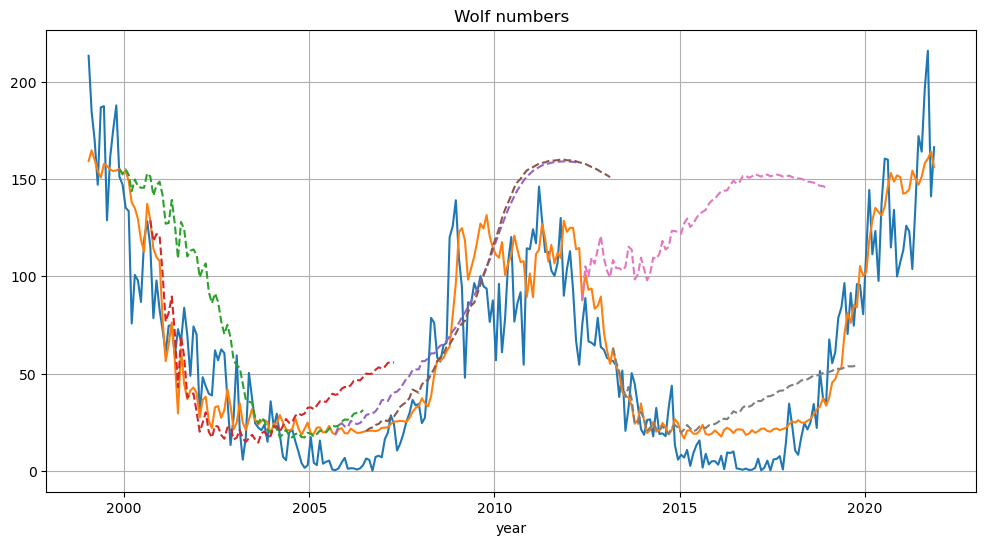

In [131]:
plt_t = sol_df['YEARF'][split_point:-LOOKBACK-FWD_SCOPE]

time = len(plt_t)

with torch.no_grad():
    y_pred=model(X_val)


def sequential_forward(model, x_init, fwd):

    assert x_init.shape[0] == LOOKBACK

    y_seq = torch.zeros(LOOKBACK+fwd)
    y_seq[0:LOOKBACK] = x_init

    with torch.no_grad():

        for t in range(0, fwd):

            y_seq[t+LOOKBACK] = model(y_seq[t:t+LOOKBACK])[0]

    return y_seq[-fwd:]


t_seq = [(10, 80), (20, 80), (80, 80), (90, 80), (160, 80), (170, 80)]
x_seq = [X_val[t[0]] for t in t_seq]
y_seq = [sequential_forward(model, x, t_seq[i][1]) for i, x in enumerate(x_seq)]

fig, ax1 = plt.subplots(1,1,figsize=(12,6))


ys_val = scaler.inverse(y_val[:, 0])
ys_pred = scaler.inverse(y_pred[:, 0])

ys_seq = [scaler.inverse(y_) for y_ in y_seq]


ax1.plot(plt_t, ys_val)
ax1.plot(plt_t, ys_pred)

for i, y_ in enumerate(ys_seq):

    t_ = plt_t[t_seq[i][0]:t_seq[i][0]+t_seq[i][1]]
    ax1.plot(t_, y_, '--')

ax1.grid('on')
ax1.set_title('Wolf numbers')
ax1.set_xlabel('year')


plt.show()